In [12]:
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
from sys import path
import os
for dirname, _, filenames in os.walk('../resources/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path.append(os.path.realpath('../'))

from custom import functions

warnings.filterwarnings('ignore')

../resources/allColProSol.xlsx
../resources/dataset_a_2021.csv
../resources/dataset_a_2021c2.csv
../resources/dataset_a_2021v1.xlsx
../resources/dataset_unab_ORIGINAL SIN P1.csv
../resources/dataset_unab_P1.csv
../resources/exitoFallidoEnviosProgramaSol.xlsx
../resources/exitoFallidoProgramaSol.xlsx
../resources/exitosoFallidosEnviosAllColProSol.xlsx
../resources/exitosoFallidosEnviosAllColSol.xlsx
../resources/exitososFallidosEnviosSol.xlsx
../resources/Hito12sinColCeroExitosoFallidosSol.xlsx
../resources/sinColCeroExitosoFallidosEnviosSol.xlsx
../resources/sinColCeroExitosoFallidosSol.xlsx
../resources/v2_hitosExitoFalloColESol1.csv
../resources/v2_hitosExitoFalloColESol1Prograna.csv
../resources/v2_hitosExitoFalloSol1Programa.csv
../resources/causalidad\causalidad_e29.dot
../resources/causalidad\graph_causal_model_e29.png
../resources/causalidad\graph_causal_model_e3.png
../resources/causalidad\graph_causal_model_e35.png
../resources/causalidad\graph_causal_model_e35_with_unobserved

In [13]:
# Read and preview data
df = pd.read_csv("../resources/v2_hitosExitoFalloColESol1.csv", delimiter=";", skipinitialspace=True)

In [14]:
#creando columna aprobado y con la funcion set_in_aprobado_nota poblamos la nueva columna.
df['aprobado']=df.apply(lambda x: functions.set_in_aprobado_nota(x['sol1']),axis = 1 )
#revisamos la existencia de la nueva columna.
print(df.columns)

Index(['hito1', 'hito2', 'exitosos', 'fallidos', 'e0', 'e1', 'e2', 'e3', 'e4',
       'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15',
       'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25',
       'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35',
       'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44', 'e45',
       'e46', 'e47', 'e48', 'e49', 'e50', 'e51', 'e52', 'sol1', 'aprobado'],
      dtype='object')


In [15]:
# Paso 1: Modelar un problema causal
model = CausalModel(
    data=df,
    treatment='e29',  # Variable tratada (exposición)
    outcome='aprobado',  # Variable de resultado
    common_causes=['e45','e35','e3']  # Variables de causa común
)

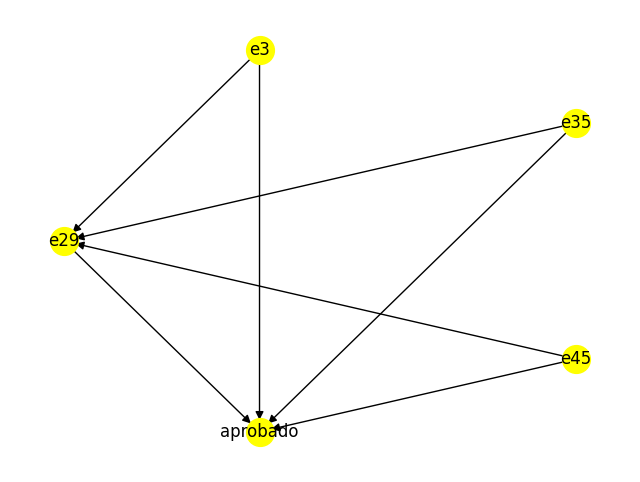

In [16]:
# Visualizar el modelo causal
model.view_model(layout="gml",file_name="../resources/causalidad/graph_causal_model_e29")

In [17]:
# Paso 2: Identificar el estimando objetivo bajo el modelo
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [18]:
# Paso 3: Estimar el efecto causal con el estimador de categoría econml TLearner
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.metalearners.TLearner",
    confidence_intervals=False,
    method_params={
        "init_params": {
            "models": RandomForestRegressor(
                max_depth=10,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=1502,
                n_estimators=500,
            )
        },
        "fit_params": {},
    },
)

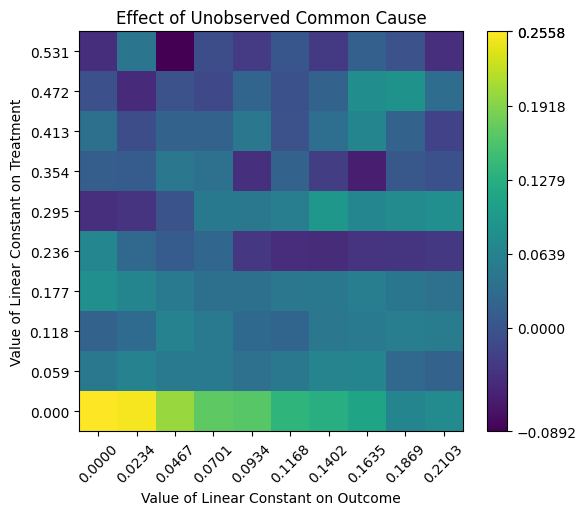

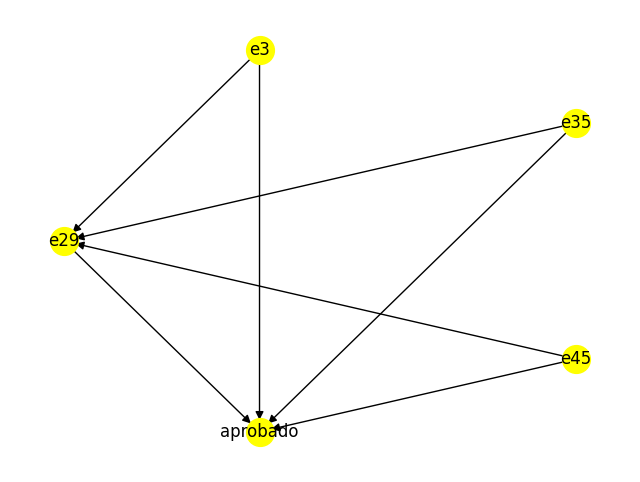

In [19]:
# Refutar el estimado obtenido con la variable de causa común no observada
refute_results_unobserved = model.refute_estimate(
    identified_estimand, 
    estimate, 
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip", 
    confounders_effect_on_outcome="binary_flip"
)

# Visualizar el modelo causal con la variable de causa común no observada
model.view_model(layout="gml", file_name="../resources/causalidad/graph_causal_model_e29_with_unobserved")

In [20]:
# Paso 4: Refutar el estimado obtenido
refute_results = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")

# Imprimir resultados RandomForestRegressor estimado de efecto causal
print("----------------------------")
print("Estimado de efecto causal:")
print(estimate.value)
print("----------------------------")

----------------------------
Estimado de efecto causal:
0.25578493952436165
----------------------------


In [21]:
# Imprimiendo estimado del backdoor utilizado, 1 es aplicable.
print("----------------------------")
print("¿Es aplicable la puerta trasera?")
print(estimate)
print("----------------------------")

----------------------------
¿Es aplicable la puerta trasera?
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                           
──────(E[aprobado|e45,e3,e35])
d[e₂₉]                        
Estimand assumption 1, Unconfoundedness: If U→{e29} and U→aprobado then P(aprobado|e29,e45,e3,e35,U) = P(aprobado|e29,e45,e3,e35)

## Realized estimand
b: aprobado~e29+e45+e3+e35
Target units: ate

## Estimate
Mean value: 0.25578493952436165
Effect estimates: [0.29343686 0.23418417 0.23418417 0.23418417 0.23418417 0.23418417
 0.23418417 0.23418417 0.23418417 0.23418417 0.23418417 0.23418417
 0.23418417 0.23418417 0.23418417 0.29343686 0.23418417 0.11810739
 0.23418417 0.23418417 0.23418417 0.23418417 0.23418417 0.23418417
 0.23418417 0.23418417 0.23418417 0.23418417 0.23418417 0.23418417
 0.23418417 0.335031   0.23418417 0.23418417 0.23418417 0.23418417
 0.23418417 0.23418417 0.23418417 0.234

In [22]:
print("----------------------------")
print("Refutación de estimado:")
print(refute_results)
print("----------------------------")

----------------------------
Refutación de estimado:
Refute: Use a Placebo Treatment
Estimated effect:0.25578493952436165
New effect:0.00801843653561311
p value:0.8

----------------------------
